# Call Volume Regression with a Neural Network

Configure jupyter stuff and import our libraries.

In [293]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from datetime import datetime
from time import time

# Set the epoch to measure time from for later
epoch = datetime.utcfromtimestamp(0)

# Set the random seed, so that we get consistent random numbers
#np.random.seed(42)

### Import data

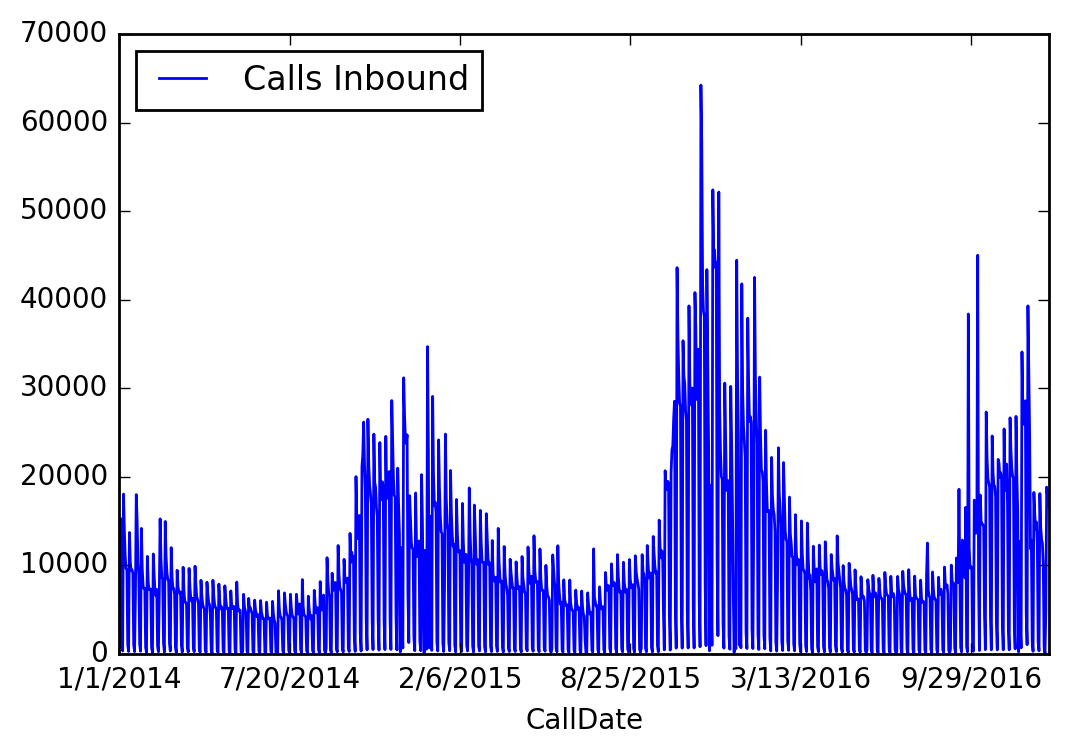

In [294]:
data_path = 'Call Volume Dataset/2014-2016 Daily Calls by Campaign.csv'
calls = pd.read_csv(data_path)
calls.plot(x='CallDate', y='Calls Inbound')

### Cleaning up the data
Most of the time, our data is in a weird state, and we need to do some sort of manipulation on it to get it into a simplistic form for our neural network to process.

In [295]:
print(calls.columns)
calls = calls[['DayOfWeek', 'CallDate', 'Calls Inbound']]

# Convert our string-based datetime into a number (millis) for ease of processing.
calls['CallDate'] = calls['CallDate'].map(lambda x: (pd.to_datetime(x) - epoch).total_seconds() * 1000.0)
dummy_fields = ['DayOfWeek']

Index(['DayOfWeek', 'CallDate', 'Calls Inbound', 'Calls Outbound',
       'Calls Inbound Handled', 'Calls Outbound Handled', 'Calls Self-Served',
       'Calls Presented', 'Calls Abandoned', 'Handle Time - Inbound Average',
       'Handle Time - Outbound Average', 'Avg.Wait Time',
       'Avg. Wait Time - Abandoned', 'Avg. Speed To Answer',
       'Avg. Speed To Answer With Transfer'],
      dtype='object')


In [296]:
# Use pd.get_dummies(...) to convert categorical columns into binary columns
for each in dummy_fields:
    dummies = pd.get_dummies(calls[each], prefix = each, drop_first=False)
    calls = pd.concat([calls, dummies], axis=1)


In [297]:
# Drop any NaN or Null values
calls = calls.drop(dummy_fields, axis=1)
#calls = calls.dropna(how='any')

#### Woah, CallDate looks weird now...
That's because we just changed the string-date to the representation of millis since the computer-time epoch.
Let's make that a bit better, by scaling the values such that they have a mean of zero and a standard deviation of 1.

In [298]:
# Pick out our quantitative features, so we can convert them
quant_features = ['CallDate', 'Calls Inbound']

# We will store our scalings in a dictionary so we can convert back to quantitative values later.
scaled_features = {}

for each in quant_features:
    mean, std = calls[each].mean(), calls[each].std()
    scaled_features[each] = [mean, std]
    calls.loc[:, each] = (calls[each] - mean)/std

calls.head()

,CallDate,Calls Inbound,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,-1.728627,-0.911964,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.725467,0.665241,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.722306,0.362257,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.719146,-0.880225,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.715986,-0.963093,0.0,0.0,0.0,1.0,0.0,0.0,0.0


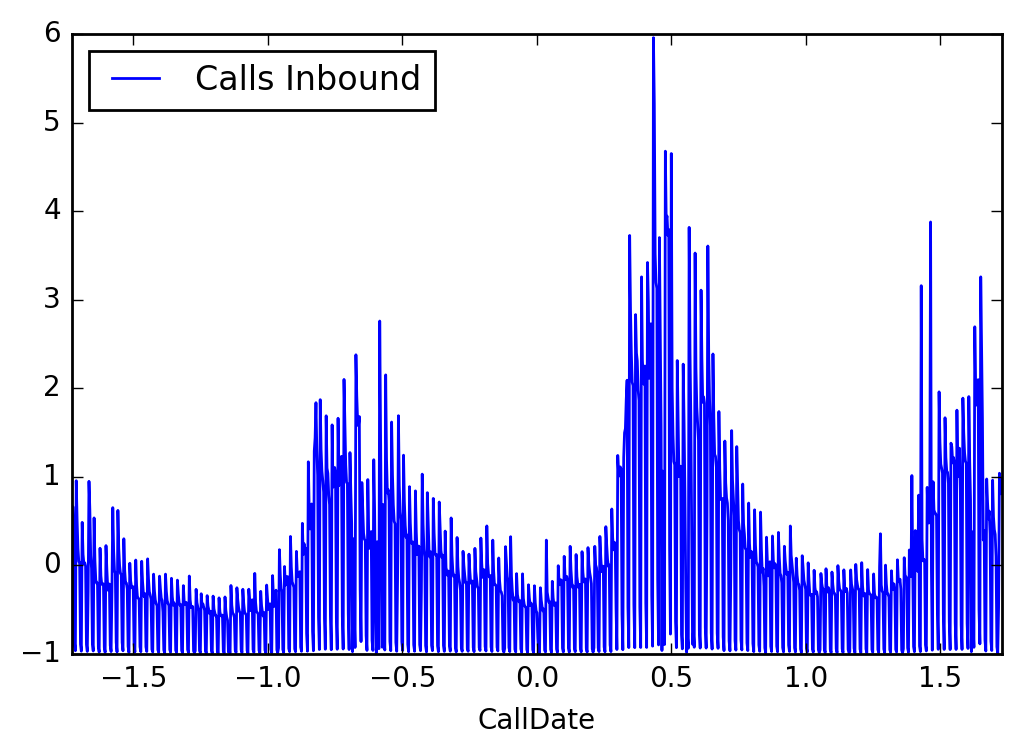

In [299]:
calls.plot(x='CallDate', y='Calls Inbound')

#### Ahh, that looks better... I think...
And you're right! Having the data in this form makes things much nicer going though the matrix math.

### Splitting the data into train/test sets

In [314]:
# Set our training size to about 80% of our total available data
training_size = 0.8
# And set the testing size to the remaining percentage
testing_size = 1.0 - training_size

# Split calls into training and testing sets
calls_training =  calls[0:int(len(calls) * training_size)]
calls_test = calls[(int(len(calls) * testing_size))+1:]
print("training: ", calls_training.drop(target_fields, axis=1).shape)
print("test: ", calls_test.drop(target_fields, axis=1).shape)

# Split features and labels(targets)
target_fields = ['Calls Inbound']
features, targets = calls_training.drop(target_fields, axis=1), calls_training[target_fields]
test_features, test_targets = calls_test.drop(target_fields, axis=1), calls_test[target_fields]

training:  (874, 8)
test:  (874, 8)


In [315]:
features.shape

(874, 8)

In [316]:
targets.shape

(874, 1)

In [317]:
# Hold on to the last 60 days of the remaining training data to use as validation for tuning our model.
train_features, train_targets = features[:-60], targets[:-60]
val_features, val_targets = features[-60:], targets[-60:]

### Let's check what shapes we have now, to make sure they can math together

In [345]:
train_features.shape

(814, 8)

In [319]:
train_targets.shape

(814, 1)

In [320]:
val_features.shape

(60, 8)

In [321]:
val_targets.shape

(60, 1)

## Time to build the network!

In [322]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [323]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, activation_function=sigmoid):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.DEBUG = True

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        self.activation_function = activation_function
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
           
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error
        output_errors = targets - final_outputs # Output layer error is the difference between desired target and actual output.
        
        def deriv(y):
            return ((y) * (1 - (y)))
        
        # TODO: Backpropagated error        
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)
        hidden_grad = deriv(hidden_outputs) 
        
        # TODO: Calculate the weight deltas
        delta_output_weights = self.lr * output_errors * hidden_outputs.T      
        delta_input_weights = self.lr * hidden_errors * hidden_grad * inputs.T
        
        # Actually update the weights
        self.weights_hidden_to_output += delta_output_weights
        self.weights_input_to_hidden += delta_input_weights
       
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)# signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [324]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Train the model and check against validation set

In [342]:
import sys

### Set the hyperparameters here ###
epochs = 2000
learning_rate = 0.01
hidden_nodes = 6
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate, sigmoid)
losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['Calls Inbound']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['Calls Inbound'].values)
    val_loss = MSE(network.run(val_features), val_targets['Calls Inbound'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.513 ... Validation loss: 1.933

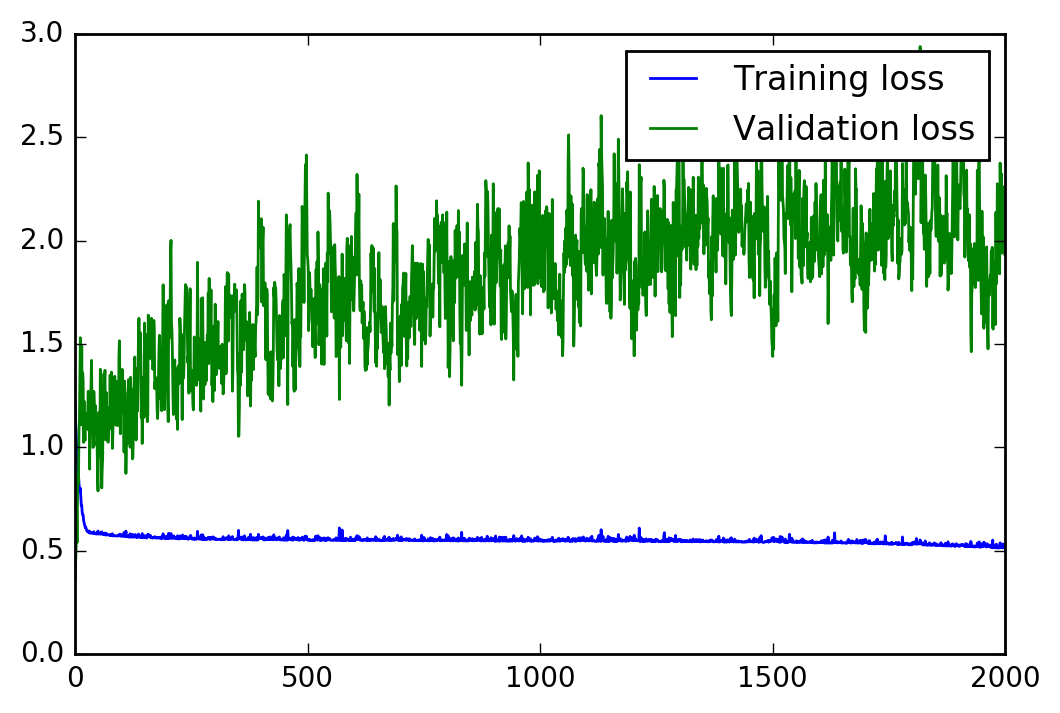

In [343]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
#plt.ylim(ymax=0.5)

## Check your predictions

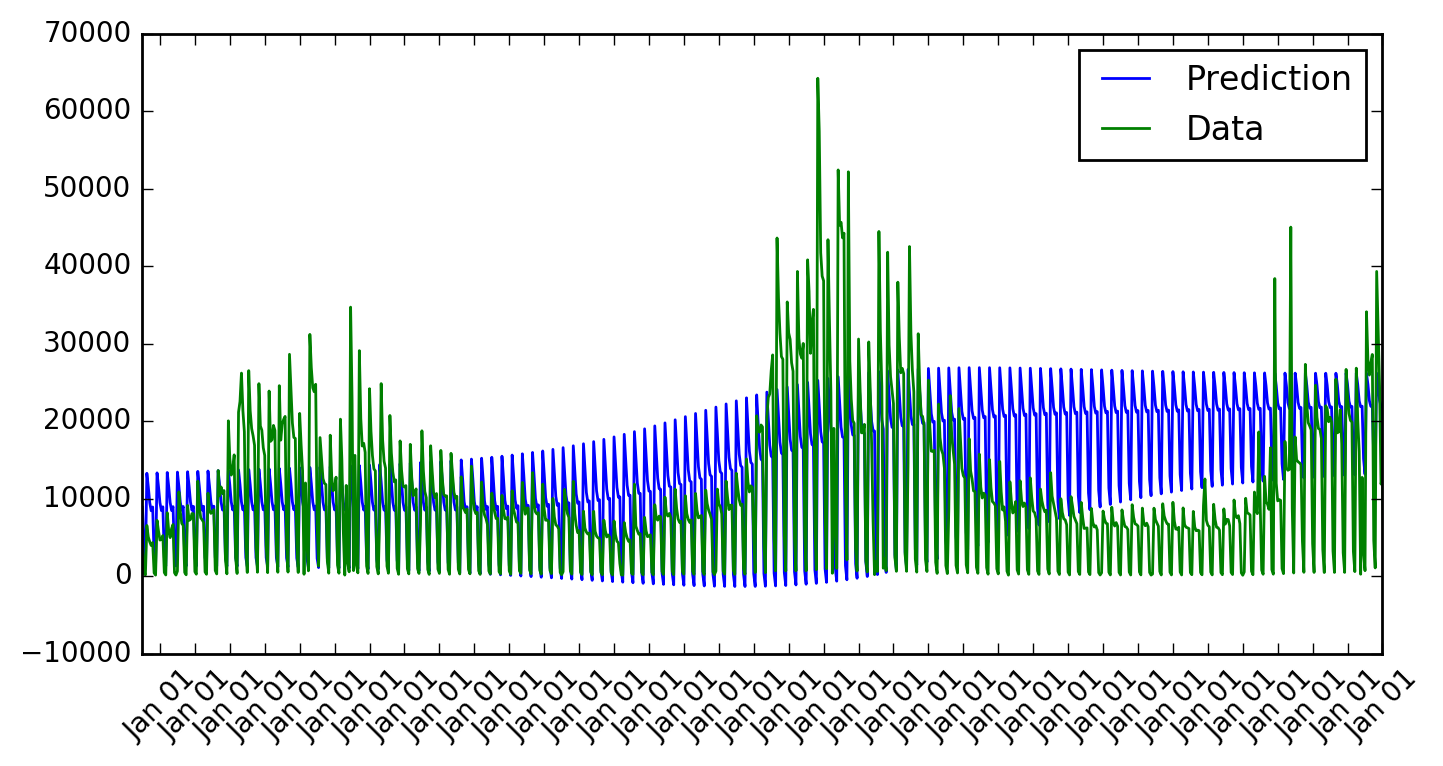

In [344]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['Calls Inbound']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['Calls Inbound']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(calls.ix[calls_test.index]['CallDate'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

# Aaaand we're done!